# NAM Dataset Analysis Using Spark
## By: Melanie Baybay

[Project 3: Deliverable I Description](https://www.cs.usfca.edu/~mmalensek/courses/cs686/projects/project-3.html#deliverable-i-individual-work)

#### Resources: 
- [Data Dictionary](https://www.cs.usfca.edu/~mmalensek/courses/cs686/projects/project-2-data.html#cs686-project-2-data-dictionary)
- [PySpark SQL Docs](http://spark.apache.org/docs/2.1.0/api/python/pyspark.sql.html#module-pyspark.sql)
- [PySpark Statistics Docs](http://spark.apache.org/docs/2.0.0/api/python/pyspark.mllib.html#module-pyspark.mllib.stat)
- [PyGeohash Docs](https://github.com/vinsci/geohash)
- [Seaborn Docs](https://seaborn.pydata.org/examples/index.html)

---
# SETUP

In [1]:
from pyspark.sql.types import StructType, StructField, FloatType, LongType, StringType, TimestampType
import pyspark.sql.functions as F
from pyspark.mllib.stat import Statistics as stats
import pygeohash as geohash
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

**Global Variables**

In [2]:
ftrs_filepath = 'features.txt'
# data_filepath = 'nam_mini.tdv'
data_filepath = 'mini-sample.tdv'

Build dataset schema

In [3]:
feats = []
f = open(ftrs_filepath)
for line_num, line in enumerate(f):
    if line_num == 0:
        # Timestamp
        feats.append(StructField(line.strip(), LongType(), True))
    elif line_num == 1:
        # Geohash
        feats.append(StructField(line.strip(), StringType(), True))
    else:
        # Other features
        feats.append(StructField(line.strip(), FloatType(), True))
    
schema = StructType(feats)

In [4]:
print(schema[:5])

StructType(List(StructField(Timestamp,LongType,true),StructField(Geohash,StringType,true),StructField(geopotential_height_lltw,FloatType,true),StructField(water_equiv_of_accum_snow_depth_surface,FloatType,true),StructField(drag_coefficient_surface,FloatType,true)))


Use schema to create a DataFrame. Load data from tdv file. 

In [5]:
raw_df = spark.read.format('csv').option('sep', '\t').schema(schema).load(data_filepath)

---

# ANALYSIS
**[3 pt]** Spark provides a different programming paradigm compared to MapReduce. Choose three of the questions from the previous assignment (not including the record count), and re-implement them using Spark.

For this question, provide an overview of your experience with these jobs: did they complete faster? Was the programming model better or worse? Which did you prefer?

In [6]:
fmt = "MM-yyyy"
df = raw_df.withColumn("Timestamp", F.to_date(F.from_unixtime(raw_df['Timestamp'] / 1000, format=fmt), format=fmt))

In [7]:
df.take(1)

[Row(Timestamp=datetime.date(2015, 4, 1), Geohash='dtb8zh79hs80', geopotential_height_lltw=1729.817138671875, water_equiv_of_accum_snow_depth_surface=0.0, drag_coefficient_surface=0.0, sensible_heat_net_flux_surface=13.718368530273438, categorical_ice_pellets_yes1_no0_surface=0.0, visibility_surface=24221.205078125, number_of_soil_layers_in_root_zone_surface=0.0, categorical_freezing_rain_yes1_no0_surface=0.0, pressure_reduced_to_msl_msl=100951.0, upward_short_wave_rad_flux_surface=0.0, relative_humidity_zerodegc_isotherm=62.0, categorical_snow_yes1_no0_surface=0.0, u-component_of_wind_tropopause=47.37763977050781, surface_wind_gust_surface=4.7406392097473145, total_cloud_cover_entire_atmosphere=100.0, upward_long_wave_rad_flux_surface=411.655029296875, land_cover_land1_sea0_surface=0.0, vegitation_type_as_in_sib_surface=0.0, v-component_of_wind_pblri=-0.27825927734375, albedo_surface=6.0, lightning_surface=0.0, ice_cover_ice1_no_ice0_surface=0.0, convective_inhibition_surface=-0.16357

### a.) Are there any Geohashes that have snow depths greater than zero for the entire year? List some of the top Geohashes.

In [8]:
snow_df = df.filter(df.snow_depth_surface > 0)

In [9]:
snow_geos = snow_df.select("Geohash").distinct().collect()

In [10]:
len(snow_geos)

108408

In [11]:
snow_geos[:3]

[Row(Geohash='9wujyzpsb5kp'),
 Row(Geohash='c2phkmdmrpkp'),
 Row(Geohash='c6hcynnqebeb')]

### b.) What is the driest month in the bay area? This should include a histogram with data from each month. (Note: how did you determine what data points are in the bay area**

In [12]:
def init_bay_area_geo_list():
    upper_lat = 38.32
    lower_lat = 37.07
    lower_lon = -123.04
    upper_lon = -121.63
    
    lat_gap = (upper_lat - lower_lat) / 7
    lon_gap = (lower_lon - upper_lon) / 4
    top_left_lat = upper_lat - (lat_gap / 2)
    top_left_lon = lower_lon - (lon_gap / 2)
    
    # get 7 center-point latitudes 
    lats = []
    lat = top_left_lat
    for i_lat in range(7):
        lats.append(lat)
        lat = lat - lat_gap
        
    # get 4 center-point longitudes
    longs = []
    lon = top_left_lon
    for i_lon in range(4): 
        longs.append(lon)
        lon = lon - lon_gap
        
    geohashes = []
    for i in range(7):
        for j in range(4):
            geohashes.append(geohash.encode(lats[i], longs[j], precision=4))

    return geohashes

Initialize bay area geohash list

In [13]:
bay_area_geos = init_bay_area_geo_list()

Filter data for observations in the Bay Area

In [14]:
bay_area_nam = df.filter(df.Geohash.substr(0, 4).isin(bay_area_geos))
bay_area_nam.take(1)

[Row(Timestamp=datetime.date(2015, 4, 1), Geohash='9q9r62cj75s0', geopotential_height_lltw=1335.2265625, water_equiv_of_accum_snow_depth_surface=0.0, drag_coefficient_surface=0.0, sensible_heat_net_flux_surface=-17.169296264648438, categorical_ice_pellets_yes1_no0_surface=0.0, visibility_surface=5824.98974609375, number_of_soil_layers_in_root_zone_surface=3.0, categorical_freezing_rain_yes1_no0_surface=0.0, pressure_reduced_to_msl_msl=100875.0, upward_short_wave_rad_flux_surface=0.0, relative_humidity_zerodegc_isotherm=99.0, categorical_snow_yes1_no0_surface=0.0, u-component_of_wind_tropopause=43.19456481933594, surface_wind_gust_surface=12.384772300720215, total_cloud_cover_entire_atmosphere=100.0, upward_long_wave_rad_flux_surface=355.3033447265625, land_cover_land1_sea0_surface=1.0, vegitation_type_as_in_sib_surface=8.0, v-component_of_wind_pblri=12.555352210998535, albedo_surface=17.0, lightning_surface=0.0, ice_cover_ice1_no_ice0_surface=0.0, convective_inhibition_surface=-8.97753

Group by month and calculate average precipitation

In [15]:
bay_area_nam.groupBy("Timestamp").mean("precipitable_water_entire_atmosphere").collect()

[Row(Timestamp=datetime.date(2015, 4, 1), avg(precipitable_water_entire_atmosphere)=13.176793931170208),
 Row(Timestamp=datetime.date(2015, 8, 1), avg(precipitable_water_entire_atmosphere)=17.951878468967177),
 Row(Timestamp=datetime.date(2015, 2, 1), avg(precipitable_water_entire_atmosphere)=14.778396462931216),
 Row(Timestamp=datetime.date(2015, 6, 1), avg(precipitable_water_entire_atmosphere)=17.531964415057576),
 Row(Timestamp=datetime.date(2015, 12, 1), avg(precipitable_water_entire_atmosphere)=14.808884162620958),
 Row(Timestamp=datetime.date(2015, 3, 1), avg(precipitable_water_entire_atmosphere)=12.97494530984772),
 Row(Timestamp=datetime.date(2015, 7, 1), avg(precipitable_water_entire_atmosphere)=22.837172660631),
 Row(Timestamp=datetime.date(2015, 10, 1), avg(precipitable_water_entire_atmosphere)=19.172180623424296),
 Row(Timestamp=datetime.date(2015, 9, 1), avg(precipitable_water_entire_atmosphere)=17.56975182576395),
 Row(Timestamp=datetime.date(2015, 5, 1), avg(precipitable

### c.) Given a Geohash prefix, create a climate chart for the region. This includes high, low, and average temperatures, as well as monthly average rainfall (precipitation). 

In [16]:
user_geo = "9q8"

Filter df for rows that match user-defined geohash

In [17]:
region_df = df.filter(df.Geohash.substr(0, len(user_geo)).startswith(user_geo))

In [18]:
region_df.count()

2677

In [19]:
grouped_region = region_df.groupBy("Timestamp")

Method #1: Individual Calculation

In [20]:
high_temps = grouped_region.max('temperature_surface').collect()
low_temps = grouped_region.min('temperature_surface').collect()
avg_temps = grouped_region.avg('temperature_surface').collect()
avg_rain = grouped_region.avg('precipitable_water_entire_atmosphere')

In [21]:
print("High temps: {}".format(high_temps))

High temps: [Row(Timestamp=datetime.date(2015, 4, 1), max(temperature_surface)=298.092041015625), Row(Timestamp=datetime.date(2015, 8, 1), max(temperature_surface)=308.845703125), Row(Timestamp=datetime.date(2015, 2, 1), max(temperature_surface)=291.14007568359375), Row(Timestamp=datetime.date(2015, 6, 1), max(temperature_surface)=298.681640625), Row(Timestamp=datetime.date(2015, 12, 1), max(temperature_surface)=288.6158447265625), Row(Timestamp=datetime.date(2015, 3, 1), max(temperature_surface)=295.82366943359375), Row(Timestamp=datetime.date(2015, 7, 1), max(temperature_surface)=306.029296875), Row(Timestamp=datetime.date(2015, 10, 1), max(temperature_surface)=301.82568359375), Row(Timestamp=datetime.date(2015, 9, 1), max(temperature_surface)=299.048583984375), Row(Timestamp=datetime.date(2015, 5, 1), max(temperature_surface)=298.6064453125), Row(Timestamp=datetime.date(2015, 1, 1), max(temperature_surface)=289.25714111328125), Row(Timestamp=datetime.date(2015, 11, 1), max(temperatu

Method #2: List comprehension

In [22]:
cols = ['temperature_surface']
funcs = [F.max, F.min, F.avg]
exprs = [f(x) for x in cols for f in funcs]
exprs.append(F.avg('precipitable_water_entire_atmosphere'))
print(exprs)

[Column<b'max(temperature_surface)'>, Column<b'min(temperature_surface)'>, Column<b'avg(temperature_surface)'>, Column<b'avg(precipitable_water_entire_atmosphere)'>]


In [23]:
results = grouped_region.agg(*exprs).toPandas()

In [24]:
results.sort_values('Timestamp', ascending=True, inplace=True)

In [25]:
results.reset_index(inplace=True)
results.drop('index', axis=1, inplace=True)

In [26]:
results

,Timestamp,max(temperature_surface),min(temperature_surface),avg(temperature_surface),avg(precipitable_water_entire_atmosphere)
0,2015-01-01,289.257141,280.051819,287.123029,13.291360
1,2015-02-01,291.140076,283.578003,287.400391,15.343026
2,2015-03-01,295.823669,282.383179,287.232194,13.020425
3,2015-04-01,298.092041,281.697083,285.633568,12.931769
4,2015-05-01,298.606445,282.981873,285.620847,14.944977
5,2015-06-01,298.681641,283.980469,287.348135,17.426049
6,2015-07-01,306.029297,285.715576,289.940131,24.348855
7,2015-08-01,308.845703,288.822998,291.068560,19.040381
8,2015-09-01,299.048584,286.892334,290.414897,18.683716
9,2015-10-01,301.825684,288.650635,291.130835,20.267960


In [27]:
results.rename(columns={'max(temperature_surface)': 'high_temp', 'min(temperature_surface)': 'low_temp', 'avg(temperature_surface)': 'avg_temp', 'avg(precipitable_water_entire_atmosphere)': 'avg_precip'}, inplace=True)

In [28]:
results

,Timestamp,high_temp,low_temp,avg_temp,avg_precip
0,2015-01-01,289.257141,280.051819,287.123029,13.291360
1,2015-02-01,291.140076,283.578003,287.400391,15.343026
2,2015-03-01,295.823669,282.383179,287.232194,13.020425
3,2015-04-01,298.092041,281.697083,285.633568,12.931769
4,2015-05-01,298.606445,282.981873,285.620847,14.944977
5,2015-06-01,298.681641,283.980469,287.348135,17.426049
6,2015-07-01,306.029297,285.715576,289.940131,24.348855
7,2015-08-01,308.845703,288.822998,291.068560,19.040381
8,2015-09-01,299.048584,286.892334,290.414897,18.683716
9,2015-10-01,301.825684,288.650635,291.130835,20.267960


In [29]:
def KtoF(temp_k): 
    return temp_k * 9/5 - 459.67

In [30]:
results.high_temp = results.high_temp.apply(KtoF)

In [31]:
results.low_temp = results.low_temp.apply(KtoF)

In [32]:
results.avg_temp = results.avg_temp.apply(KtoF)

In [33]:
results.Timestamp = results.Timestamp.apply(lambda date: date.month)

In [34]:
results

,Timestamp,high_temp,low_temp,avg_temp,avg_precip
0,1,60.992854,44.423274,57.151452,13.291360
1,2,64.382136,50.770405,57.650704,15.343026
2,3,72.812605,48.619722,57.347949,13.020425
3,4,76.895674,47.384749,54.470422,12.931769
4,5,77.821602,49.697371,54.447524,14.944977
5,6,77.956953,51.494844,57.556643,17.426049
6,7,91.182734,54.618037,62.222236,24.348855
7,8,96.252266,60.211396,64.253408,19.040381
8,9,78.617451,56.736201,63.076814,18.683716
9,10,83.616230,59.901143,64.365503,20.267960


In [35]:
results.avg_temp.iloc[1]

57.650704123757066

In [36]:
# modified from malensek: https://raw.githubusercontent.com/malensek/climate-chart/master/plot.py

import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec
import matplotlib
from matplotlib import rc

In [37]:
def disable_spines(ax):
    for s in ax.spines:
        ax.spines[s].set_visible(False)

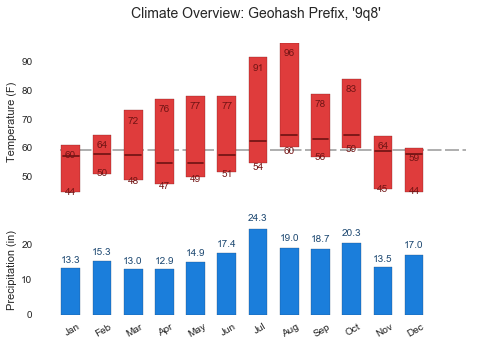

In [38]:
rc('font',**{'family':'sans-serif','sans-serif':['Arial']})

plt.ion()
plt.clf()
fig = plt.figure(figsize=(8, 5))
fig.subplots_adjust(hspace=.20)
gs = gridspec.GridSpec(2, 1, height_ratios=[1.75, 1])
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1], sharex=ax0)
plt.setp(ax0.get_xticklabels(), visible=False) # disable upper axis label

ax0.patch.set_facecolor('None')
ax1.patch.set_facecolor('None')

plt.suptitle('Climate Overview: ' + "Geohash Prefix, '{}'".format(user_geo), fontsize=14)

y = np.mean(results.avg_temp)
ax0.plot([0, results.Timestamp.max() + 1],  [y, y], zorder=-1, color='#888888',
         alpha=.75, dashes=(8, 2))

rects0 = ax0.bar(.35 + results.Timestamp - 1, results.low_temp - results.high_temp, bottom=results.high_temp,
        width=.6, color='#df3c3c', edgecolor='#731515')

rects1 = ax1.bar(.35 + results.Timestamp - 1, results.avg_precip, color='#1b7edb', width=.6,
        edgecolor='#1d4871')

plt.xticks(np.arange(0,12) + .4, ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
    'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'],
    rotation=30)

disable_spines(ax0)
disable_spines(ax1)
ax0.spines['left'].set_visible(True)
ax1.spines['left'].set_visible(True)

for tic in ax0.xaxis.get_major_ticks():
    tic.tick1On = tic.tick2On = False

for tic in ax0.yaxis.get_major_ticks():
    tic.tick2On = False

for tic in ax1.xaxis.get_major_ticks():
    tic.tick1On = tic.tick2On = False

for tic in ax1.yaxis.get_major_ticks():
    tic.tick2On = False

for rect in rects1:
    height = rect.get_height()
    ax1.text(rect.get_x() + rect.get_width()/2., 1.08*height,
        '%.1f' % (height), ha='center', va='bottom', color='#1d4871')

for r, rect in enumerate(rects0):
    height = rect.get_height()
    ax0.text(rect.get_x() + rect.get_width()/2., rect.get_y() + 1.08*height,
        '%d' % int(height + rect.get_y()), ha='center', va='bottom',
        color='#731515')
    ax0.text(rect.get_x() + rect.get_width()/2., rect.get_y() - 2,
        '%d' % int(rect.get_y()), ha='center', va='top', color='#731515')
    ax0.plot([rect.get_x() + .05, rect.get_x() + rect.get_width() - .05],
            [results.avg_temp.iloc[r], results.avg_temp.iloc[r]], color='#731515')


ax0.set_ylabel('Temperature (F)')
ax1.set_ylabel('Precipitation (in)')

# plt.savefig(outfile, bbox_inches='tight')

---

**[2 pt]** It is often useful to understand feature properties and distributions. Build a Spark job that computes summary statistics for each feature. This should include:
- Min, max values
- Average
- Standard deviation

In [39]:
summary = df.describe().toPandas()

In [40]:
summary = summary.transpose()
# summary.index

In [41]:
summary.loc["summary"]

0     count
1      mean
2    stddev
3       min
4       max
Name: summary, dtype: object

In [42]:
summary.columns = summary.loc["summary"]
summary = summary.reindex(summary.index.drop("summary"))

In [43]:
summary

summary,count,mean,stddev,min,max
Geohash,5404746,None,None,8gpfpw10qhzz,ffhyjnk2fgtb
geopotential_height_lltw,5404746,2141.460589701558,1898.1221123819798,-8015.5312,6202.4365
water_equiv_of_accum_snow_depth_surface,5404746,8.035800387291186,37.34503968059668,0.0,5649.0
drag_coefficient_surface,5404746,0.15554024185410378,39.85484170219889,0.0,48000.0
sensible_heat_net_flux_surface,5404746,2460.591012176307,49251.43240969251,-317.96582,1000000.1
categorical_ice_pellets_yes1_no0_surface,5404746,3.0547226456155386E-4,0.01747509678826262,0.0,1.0
visibility_surface,5404746,21715.863747615178,6142.599331655233,17.292929,24307.436
number_of_soil_layers_in_root_zone_surface,5404746,1.5996940466767542,1.7434935950250698,0.0,4.0
categorical_freezing_rain_yes1_no0_surface,5404746,6.860636929098981E-4,0.026183833492622318,0.0,1.0
pressure_reduced_to_msl_msl,5404746,101574.21354343016,790.8951387654217,94951.0,106272.0


---

**[2 pt]** Determine how features influence each other using Pearson’s correlation coefficient (PCC).

The output for this job should include: 
1. feature pairs sorted by absolute correlation coefficient
2. a correlation matrix visualization (heatmaps are a good option).

In [44]:
ftrs = df.rdd.map(lambda row : row[2:])

In [45]:
corr = stats.corr(ftrs, method="pearson")

In [46]:
corr_pd_df = pd.DataFrame(corr, index=df.columns[2:], columns=df.columns[2:])

In [47]:
corr_pd_df.head()

,geopotential_height_lltw,water_equiv_of_accum_snow_depth_surface,drag_coefficient_surface,sensible_heat_net_flux_surface,categorical_ice_pellets_yes1_no0_surface,visibility_surface,number_of_soil_layers_in_root_zone_surface,categorical_freezing_rain_yes1_no0_surface,pressure_reduced_to_msl_msl,upward_short_wave_rad_flux_surface,...,geopotential_height_pblri,pressure_tropopause,snow_depth_surface,v-component_of_wind_tropopause,downward_short_wave_rad_flux_surface,u-component_of_wind_maximum_wind,wilting_point_surface,precipitable_water_entire_atmosphere,u-component_of_wind_pblri,direct_evaporation_cease_soil_moisture_surface
geopotential_height_lltw,1.000000,-0.423721,0.001391,0.013413,-0.019764,0.200286,-0.227736,-0.025067,-0.156293,-0.032189,...,0.133789,-0.737011,-0.557844,0.115678,0.180488,-0.208513,-0.151631,0.754450,-0.278402,-0.151631
water_equiv_of_accum_snow_depth_surface,-0.423721,1.000000,-0.000521,-0.007169,0.005721,-0.231308,0.218166,0.015315,0.027023,0.077674,...,-0.104294,0.302176,0.888789,-0.015586,-0.070273,0.025700,0.132082,-0.257108,0.079912,0.132082
drag_coefficient_surface,0.001391,-0.000521,1.000000,-0.000180,-0.000059,0.000539,0.004662,0.000003,0.000423,0.004402,...,0.002689,-0.000361,-0.000634,0.000277,0.004277,-0.001256,0.003395,-0.000177,-0.000094,0.003395
sensible_heat_net_flux_surface,0.013413,-0.007169,-0.000180,1.000000,-0.000858,0.019504,-0.000329,-0.001306,0.006634,-0.024601,...,0.002697,-0.008762,-0.007964,0.001780,-0.032305,-0.013416,0.000045,0.015288,-0.005332,0.000045
categorical_ice_pellets_yes1_no0_surface,-0.019764,0.005721,-0.000059,-0.000858,1.000000,-0.045931,0.014774,-0.000458,-0.001613,-0.003818,...,-0.002696,0.004869,0.008300,0.017889,-0.009326,0.018143,0.013103,-0.004342,-0.018436,0.013103


In [48]:
# corr_pd_df.dtypes

In [49]:
corr_pd_df = corr_pd_df.astype(float)

1.) Feature Pairs sorted by absolute correlation coefficient

In [50]:
corr_df = corr_pd_df.reset_index()

In [51]:
ftr_pairs = corr_df.melt(id_vars=['index'])
ftr_pairs.rename(columns={'index': 'ftr1', 'variable': 'ftr2', 'value': 'corr'}, inplace=True)
ftr_pairs.sort_values(by='corr', ascending=False, inplace=True)

In [52]:
ftr_pairs.head(10)

,ftr1,ftr2,corr
0,geopotential_height_lltw,geopotential_height_lltw,1.0
855,upward_long_wave_rad_flux_surface,upward_long_wave_rad_flux_surface,1.0
1482,vegetation_surface,vegetation_surface,1.0
1425,soil_porosity_surface,soil_porosity_surface,1.0
1368,transpiration_stress-onset_soil_moisture_surface,transpiration_stress-onset_soil_moisture_surface,1.0
1311,pressure_surface,pressure_surface,1.0
1254,convective_inhibition_surface,convective_inhibition_surface,1.0
1197,ice_cover_ice1_no_ice0_surface,ice_cover_ice1_no_ice0_surface,1.0
1140,lightning_surface,lightning_surface,1.0
1083,albedo_surface,albedo_surface,1.0


In [53]:
corr_pd_df.head()

,geopotential_height_lltw,water_equiv_of_accum_snow_depth_surface,drag_coefficient_surface,sensible_heat_net_flux_surface,categorical_ice_pellets_yes1_no0_surface,visibility_surface,number_of_soil_layers_in_root_zone_surface,categorical_freezing_rain_yes1_no0_surface,pressure_reduced_to_msl_msl,upward_short_wave_rad_flux_surface,...,geopotential_height_pblri,pressure_tropopause,snow_depth_surface,v-component_of_wind_tropopause,downward_short_wave_rad_flux_surface,u-component_of_wind_maximum_wind,wilting_point_surface,precipitable_water_entire_atmosphere,u-component_of_wind_pblri,direct_evaporation_cease_soil_moisture_surface
geopotential_height_lltw,1.000000,-0.423721,0.001391,0.013413,-0.019764,0.200286,-0.227736,-0.025067,-0.156293,-0.032189,...,0.133789,-0.737011,-0.557844,0.115678,0.180488,-0.208513,-0.151631,0.754450,-0.278402,-0.151631
water_equiv_of_accum_snow_depth_surface,-0.423721,1.000000,-0.000521,-0.007169,0.005721,-0.231308,0.218166,0.015315,0.027023,0.077674,...,-0.104294,0.302176,0.888789,-0.015586,-0.070273,0.025700,0.132082,-0.257108,0.079912,0.132082
drag_coefficient_surface,0.001391,-0.000521,1.000000,-0.000180,-0.000059,0.000539,0.004662,0.000003,0.000423,0.004402,...,0.002689,-0.000361,-0.000634,0.000277,0.004277,-0.001256,0.003395,-0.000177,-0.000094,0.003395
sensible_heat_net_flux_surface,0.013413,-0.007169,-0.000180,1.000000,-0.000858,0.019504,-0.000329,-0.001306,0.006634,-0.024601,...,0.002697,-0.008762,-0.007964,0.001780,-0.032305,-0.013416,0.000045,0.015288,-0.005332,0.000045
categorical_ice_pellets_yes1_no0_surface,-0.019764,0.005721,-0.000059,-0.000858,1.000000,-0.045931,0.014774,-0.000458,-0.001613,-0.003818,...,-0.002696,0.004869,0.008300,0.017889,-0.009326,0.018143,0.013103,-0.004342,-0.018436,0.013103


2.) Heatmap of Correlation Matrix

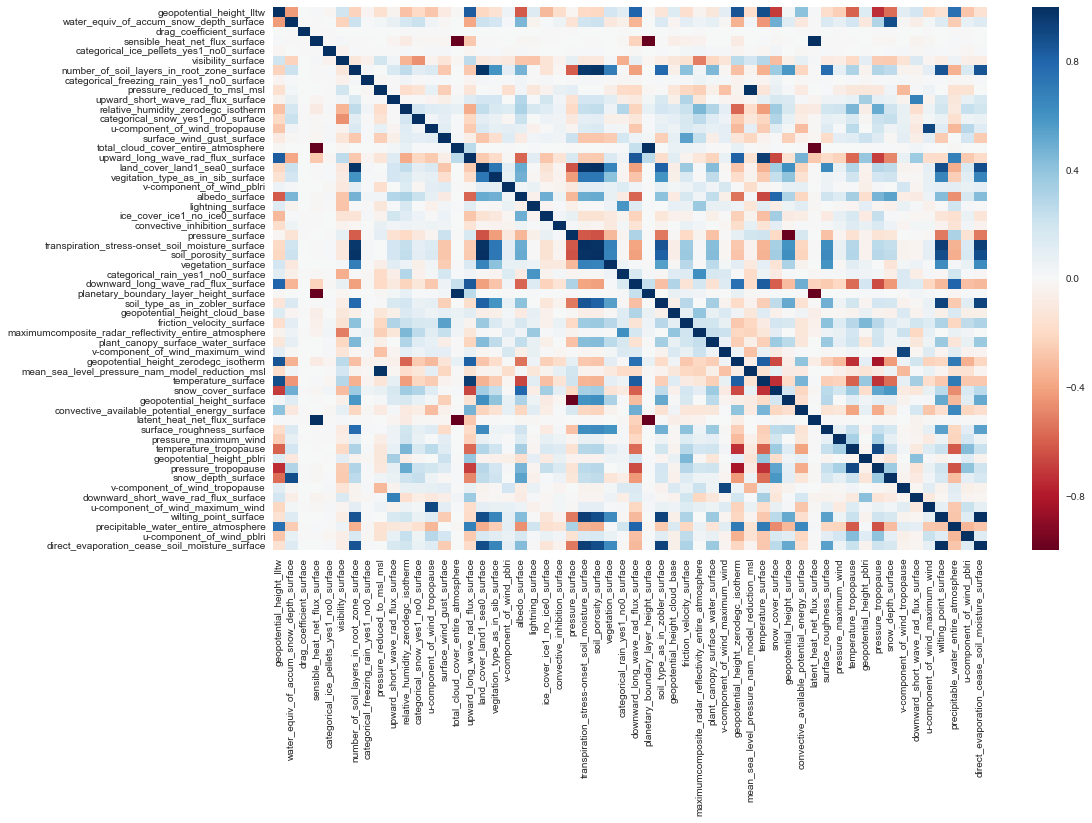

In [54]:
fig, ax = plt.subplots(figsize=(16, 10))
sns.heatmap(corr_pd_df, cmap="RdBu")

--- 

**[2 pt]** Using the feature summaries and correlations as your guide, choose a feature to predict via machine learning models in MLlib.

- Goal: Predict % of vegetation (vegetation_surface feature), based on time, soil, and water related features. 
- Potential Features: direct_evaporation_cease_soil_moisture_surface, wilting_point_surface, surface_roughness_surface, soil_type_as_in_zolber_surface, soil_porosity_surface, transpiration_stress-onset_soil_moisture_surface, number_of_soil_layers_in_root_zone_surface, temperature_surface
- Filter original dataset by: land_cover_land1_sea0_surface == 1 (only land geohashes)
- How you partitioned your data: 
- Why the model choices make sense (for example: if two features are highly correlated, then perhaps you don’t need a model…)

In [55]:
from pyspark.ml import Pipeline
from pyspark.ml.regression import RandomForestRegressor, LinearRegression
from pyspark.ml.feature import VectorIndexer, VectorAssembler
from pyspark.ml.evaluation import RegressionEvaluator

filter original dataset for land observations

In [56]:
land_df = df.filter(df.land_cover_land1_sea0_surface == 1)

In [57]:
land_df = land_df.select(["direct_evaporation_cease_soil_moisture_surface", "wilting_point_surface", 
                "surface_roughness_surface", "soil_type_as_in_zobler_surface", "soil_porosity_surface", 
                "transpiration_stress-onset_soil_moisture_surface", "number_of_soil_layers_in_root_zone_surface", 
                "temperature_surface", "vegetation_surface"])

In [58]:
land_df.toPandas().shape

(2530340, 9)

## Attempt 1: Random Forests

In [59]:
train, test = land_df.randomSplit([0.7, 0.3])

In [60]:
train_labels = train.select("vegetation_surface")
test_labels = test.select("vegetation_surface")

In [61]:
train_labels.take(1)

[Row(vegetation_surface=1.0)]

In [62]:
featureVector = VectorAssembler(inputCols=[col for col in land_df.columns if col != "vegetation_surface"], 
                               outputCol="features")

In [63]:
# Train a RandomForest model.
rf = RandomForestRegressor(featuresCol="features", labelCol="vegetation_surface")

In [64]:
# Chain indexer and forest in a Pipeline
pipeline = Pipeline(stages=[featureVector, rf])

In [65]:
# Train model.  This also runs the indexer.
model = pipeline.fit(train)

In [66]:
# Make predictions.
predictions = model.transform(test)

In [67]:
# Select example rows to display.
predictions.select("prediction", "features").show(5)

+------------------+--------------------+
|        prediction|            features|
+------------------+--------------------+
|13.479255911246327|[0.02249999903142...|
|13.479255911246327|[0.02249999903142...|
|15.751661568764124|[0.02249999903142...|
| 19.31535135283136|[0.02249999903142...|
|20.018182206148147|[0.02249999903142...|
+------------------+--------------------+
only showing top 5 rows



In [68]:
# Select (prediction, true label) and compute test error
evaluator = RegressionEvaluator(
    labelCol="vegetation_surface", predictionCol="prediction", metricName="rmse")

In [69]:
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 16.6339


In [70]:
rfModel = model.stages[1]
print(rfModel)  # summary only

RandomForestRegressionModel (uid=RandomForestRegressor_42238fc1380b1763ff87) with 20 trees


Plot Lag Plot

In [71]:
test = test.withColumn('vegetation_surface', test.vegetation_surface.astype("float"))
predictions = predictions.withColumn('prediction', predictions.prediction.astype("float"))

In [72]:
actual_vegetation = test.select('vegetation_surface').rdd.flatMap(lambda x : x).collect()

In [73]:
pred_vegetation = predictions.select('prediction').rdd.flatMap(lambda x : x).collect()

In [74]:
lag_vegetation = pd.DataFrame(data={"actual": actual_vegetation, "pred": pred_vegetation}, dtype=float)

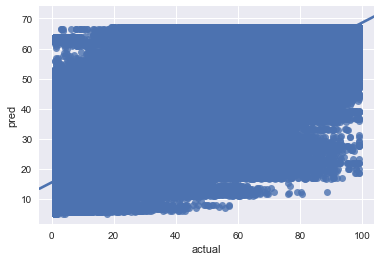

In [75]:
sns.regplot("actual", "pred", data=lag_vegetation)

Random Forests performed SUPER poorly for this one... let's simplify and try Linear Regression. 

## Attempt 2: Linear Regression

In [76]:
train, test = land_df.randomSplit([0.7, 0.3])

In [77]:
featureVector = VectorAssembler(inputCols=[col for col in land_df.columns if col != "vegetation_surface"], 
                               outputCol="features")

In [78]:
lr_A = LinearRegression(featuresCol="features", labelCol="vegetation_surface")
lr_B = LinearRegression(featuresCol="features", labelCol="vegetation_surface", regParam=100.0)
lr_C = LinearRegression(featuresCol="features", labelCol="vegetation_surface", regParam=50.0)

In [79]:
pipelineA = Pipeline(stages=[featureVector, lr_A])
pipelineB = Pipeline(stages=[featureVector, lr_B])
pipelineC = Pipeline(stages=[featureVector, lr_C])

In [80]:
modelA = pipelineA.fit(train)
modelB = pipelineB.fit(train)
modelC = pipelineC.fit(train)

In [81]:
# Make predictions.
predictionsA = modelA.transform(test)
predictionsB = modelB.transform(test)
predictionsC = modelC.transform(test)

In [82]:
# Select example rows to display.
predictionsA.select("prediction", "features").show(5)

+------------------+--------------------+
|        prediction|            features|
+------------------+--------------------+
|11.801294943534458|[0.02249999903142...|
|17.323224602355936|[0.02249999903142...|
| 17.39557250850254|[0.02249999903142...|
|19.030137492089125|[0.02249999903142...|
|19.403044820415403|[0.02249999903142...|
+------------------+--------------------+
only showing top 5 rows



In [83]:
predictionsB.select("prediction", "features").show(5)

+------------------+--------------------+
|        prediction|            features|
+------------------+--------------------+
|26.934049672309385|[0.02249999903142...|
| 28.09343878262061|[0.02249999903142...|
|28.108629011349123|[0.02249999903142...|
|28.451823684073503|[0.02249999903142...|
|  28.5301196281238|[0.02249999903142...|
+------------------+--------------------+
only showing top 5 rows



In [84]:
predictionsC.select("prediction", "features").show(5)

+------------------+--------------------+
|        prediction|            features|
+------------------+--------------------+
|23.984626913117552|[0.02249999903142...|
| 25.90849889752046|[0.02249999903142...|
| 25.93370532323857|[0.02249999903142...|
| 26.50319714455948|[0.02249999903142...|
|26.633120197925322|[0.02249999903142...|
+------------------+--------------------+
only showing top 5 rows



In [85]:
# Select (prediction, true label) and compute test error
evaluator = RegressionEvaluator(
    labelCol="vegetation_surface", predictionCol="prediction", metricName="rmse")

In [86]:
rmseA = evaluator.evaluate(predictionsA)
rmseB = evaluator.evaluate(predictionsB)
rmseC = evaluator.evaluate(predictionsC)
print("ModelA (reg=0.0) Root Mean Squared Error (RMSE) on test data = %g" % rmseA)
print("ModelB (reg=100.0) Root Mean Squared Error (RMSE) on test data = %g" % rmseB)
print("ModelC (reg=50.0) Root Mean Squared Error (RMSE) on test data = %g" % rmseC)

ModelA (reg=0.0) Root Mean Squared Error (RMSE) on test data = 19.2702
ModelB (reg=100.0) Root Mean Squared Error (RMSE) on test data = 24.0461
ModelC (reg=50.0) Root Mean Squared Error (RMSE) on test data = 22.6923


Plot Lag Plot

In [87]:
test = test.withColumn('vegetation_surface', test.vegetation_surface.astype("float"))
predictionsA = predictionsA.withColumn('prediction', predictionsA.prediction.astype("float"))
predictionsB = predictionsB.withColumn('prediction', predictionsB.prediction.astype("float"))
predictionsC = predictionsC.withColumn('prediction', predictionsC.prediction.astype("float"))

In [88]:
actual = test.select('vegetation_surface').rdd.flatMap(lambda x : x).collect()
pred_A = predictionsA.select('prediction').rdd.flatMap(lambda x : x).collect()
pred_B = predictionsB.select('prediction').rdd.flatMap(lambda x : x).collect()
pred_C = predictionsC.select('prediction').rdd.flatMap(lambda x : x).collect()

In [89]:
lag_A = pd.DataFrame(data={"actual": actual, "pred": pred_A}, dtype=float)
lag_B = pd.DataFrame(data={"actual": actual, "pred": pred_B}, dtype=float)
lag_C = pd.DataFrame(data={"actual": actual, "pred": pred_C}, dtype=float)

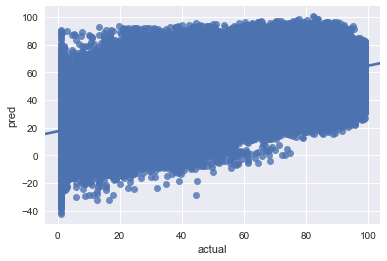

In [90]:
sns.regplot("actual", "pred", data=lag_A)

The lag plot for seems to have a 

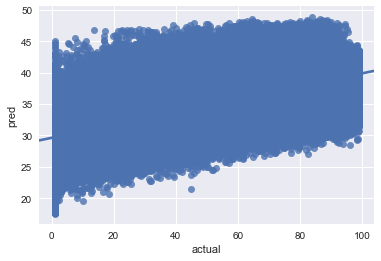

In [91]:
sns.regplot("actual", "pred", data=lag_B)

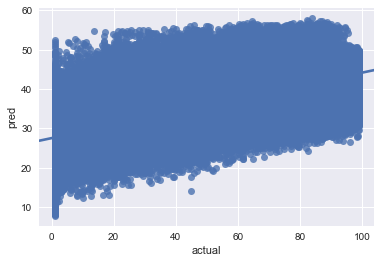

In [92]:
sns.regplot("actual", "pred", data=lag_C)

**[1 pt]** A visualization built from the dataset. You can choose absolutely any type of visualization here, but it should help tell a story about the data. 
- [Precipitation Map](https://plot.ly/python/scatter-plots-on-maps/)
- [Animation/Slider](https://plot.ly/python/ipython-notebook-tutorial/)

In [109]:
import plotly.plotly as py
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go

### Prepare CA Precipitation Data

In [94]:
CA_geos = ['9pr', '9r2', '9r3', '9r0', '9r1', '9r4', '9pr', '9pp', '9nz', '9qb', '9qc', '9qf', '9qg', '9q8', '9q9', '9qd', '9qd','9qe', '9qs', '9q3', '9q6', '9q7', '9qk', '9qm', '9qq', '9q4', '9q5', '9qh', '9qj', '9qn', '9mg', '9mu', '9mv', '9my']

In [95]:
CA_rain = df.filter(df.Geohash.substr(0, len(CA_geos[0])).isin(CA_geos))

In [96]:
CA_rain = CA_rain.groupBy("Geohash", "Timestamp").avg("precipitable_water_entire_atmosphere").alias('avg_rain')

In [97]:
CA_rain_df = CA_rain.toPandas()

In [98]:
CA_rain_df.head()

,Geohash,Timestamp,avg(precipitable_water_entire_atmosphere)
0,9qnr1k0x7zkp,2015-04-01,6.208261
1,9qkhmh59k5s0,2015-04-01,10.052879
2,9qc05p2dqzkp,2015-04-01,13.023348
3,9q72kvp15x80,2015-04-01,18.632076
4,9mv0r4nx7e2p,2015-04-01,5.874104


In [99]:
CA_rain_df['Lat'] = CA_rain_df.Geohash.apply(lambda x : geohash.decode(x)[0])

In [100]:
CA_rain_df['Lon'] = CA_rain_df.Geohash.apply(lambda x : geohash.decode(x)[1])

In [101]:
CA_rain_df['avg(precipitable_water_entire_atmosphere)'] = CA_rain_df['avg(precipitable_water_entire_atmosphere)'].apply(lambda x : x * 0.039370)

In [102]:
CA_rain_df.rename(columns={'avg(precipitable_water_entire_atmosphere)': 'Avg. Precipitation'}, inplace=True)
CA_rain_df.head()

,Geohash,Timestamp,Avg. Precipitation,Lat,Lon
0,9qnr1k0x7zkp,2015-04-01,0.244419,35.003726,-114.905153
1,9qkhmh59k5s0,2015-04-01,0.395782,35.925526,-117.900290
2,9qc05p2dqzkp,2015-04-01,0.512729,38.009002,-122.210932
3,9q72kvp15x80,2015-04-01,0.733545,35.227873,-118.961184
4,9mv0r4nx7e2p,2015-04-01,0.231263,32.399945,-116.402056


In [103]:
CA_rain_df.shape

(43377, 5)

### Plotting CA Precipitation

Color Definitions for Plot

In [104]:
scl = [0,"rgb(150,0,90)"],[0.125,"rgb(0, 0, 200)"],[0.25,"rgb(0, 25, 255)"],\
[0.375,"rgb(0, 152, 255)"],[0.5,"rgb(44, 255, 150)"],[0.625,"rgb(151, 255, 0)"],\
[0.75,"rgb(255, 234, 0)"],[0.875,"rgb(255, 111, 0)"],[1,"rgb(255, 0, 0)"]

In [105]:
def prep_data(df, user_date): 
    data = [ dict(
        lat = df[df['Timestamp'] == user_date]['Lat'],
        lon = df[df['Timestamp'] == user_date]['Lon'],
        text = df[df['Timestamp'] == user_date]['Avg. Precipitation'].astype(str) + ' inches',
        marker = dict(
            color = df[df['Timestamp'] == user_date]['Avg. Precipitation'],
            colorscale = scl,
            reversescale = True,
            opacity = 0.7,
            size = 2,
            colorbar = dict(
                thickness = 10,
                titleside = "right",
                outlinecolor = "rgba(68, 68, 68, 0)",
                ticks = "outside",
                ticklen = 3,
                showticksuffix = "last",
                ticksuffix = " inches",
                dtick = 0.1
            ),
        ),
        type = 'scattergeo'
    ) ]
    return data

In [106]:
def prep_layout(user_date):
    layout = dict(
        geo = dict(
            scope = 'north america',
            showland = True,
            landcolor = "rgb(212, 212, 212)",
            subunitcolor = "rgb(255, 255, 255)",
            countrycolor = "rgb(255, 255, 255)",
            showlakes = True,
            lakecolor = "rgb(255, 255, 255)",
            showsubunits = True,
            showcountries = True,
            resolution = 50,
            projection = dict(
                type = 'conic conformal',
                rotation = dict(
                    lon = -100
                )
            ),
            lonaxis = dict(
                showgrid = True,
                gridwidth = 0.5,
                range= [ -112.0, -126.0 ],
                dtick = 5
            ),
            lataxis = dict (
                showgrid = True,
                gridwidth = 0.5,
                range= [ 45.0, 31.0 ],
                dtick = 5
            )
        ),
        title = 'CA Precipitation {}-2015<br>Source: <a href="http://water.weather.gov/precip/">NAM</a>'.format(user_date.month)
    )
    return layout

In [107]:
def plot_CA_precip_map(df, month):
    dates = df.Timestamp.unique()
    dates.sort()
    user_date = dates[month-1]
    data = prep_data(df, user_date)
    layout = prep_layout(user_date)
    fig = {'data': data, 'layout': layout}
    fname = 'CA-Precipitation_{}-{}'.format(user_date.month, user_date.year)
    return py.iplot(fig, filename=fname, sharing='public')

### Example: Comparing CA Precipitation: March 2015 vs. October 2015

In [110]:
plot_CA_precip_map(CA_rain_df, 3)

CA Precipitation 03-2015: [Plotly Interactive Map Link](https://plot.ly/~mbaybay/242)

- Much of the plot is red/yellow and some green in central CA. This indicates low level of precipitation in March. 

In [111]:
plot_CA_precip_map(CA_rain_df, 10)

CA Precipitation 10-2015: [Plotly Interactive Map Link](https://plot.ly/~mbaybay/244)

* In October, most of the area is green/blue, indicating a much higher level of precipitation overall for the state compared to March. 

With more data of precipitation for previous and later years, we could further explore how precipitation changed during the drought. 